# **Bibliotecas**

In [1]:
%%capture

!pip install shap
!pip install optuna

In [2]:
seed = 7
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler
from optuna.visualization import plot_optimization_history

# **Funções**

O arquivo 'functions_pred_cruzada' contém as funções que serão utilizadas para selecionar, pré-processar e treinar e validar os modelos de machine learning

In [3]:
!gdown 1uVoArwRTJmvbyFLyFniwFvWGHMfiNIWO --quiet

from functions_pred_cruzada import *

# **Dados**

In [4]:
# Baixando todos os arquivos dos tipos de câncer
!gdown 1gCvb72254hSgR3uRDNnkuvypdKMDXE-E --quiet # Colorretal
!gdown 1-5TMUdCHgLEBig1F5a4rRuTT5MdT4Lrw --quiet # Pulmão
!gdown 1-AY70uv61sBGJbUFCiF8Igyes3eP6ymm --quiet # Mama
!gdown 1-ApWhBLZG4NdOtLiwlaYflR2EzTB5vV8 --quiet # Colo de Útero
!gdown 1-HKn3Rk1i9hRAK06khtSF9lf9bInZ3HS --quiet # Próstata
!gdown 1-PJi2-Tu6-AD9PVmVb5Pbx3IzVy8vnr3 --quiet # Pele

In [5]:
# Leitura dos dados de colo de útero
df_prostata = pd.read_csv('prostata.csv')
print(df_prostata.shape)
df_prostata.head(3)

(94106, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,24,1,3524402,2,2,C619,C61,I,C,0,...,17,3524402,1,2.0,1,1,0,1,1,1
1,22,1,3519204,2,2,C619,C61,I,J,1,...,10,3555000,1,2.0,0,0,0,1,0,0
2,20,1,3502804,2,1,C619,C61,II,B,0,...,12,3502804,1,2.0,1,1,0,1,1,1


In [6]:
# Valores faltantes
df_prostata.isna().sum().sort_values(ascending=False).head(6)

IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
presenca_rec      0
dtype: int64

In [7]:
df_prostata_ano3 = df_prostata[~((df_prostata.obito_geral == 0) & (df_prostata.sobrevida_ano3 == 0))].reset_index(drop=True)
df_prostata_ano3.shape

(80576, 32)

In [8]:
# Correlação com a saída
corr_matrix = df_prostata_ano3.corr()
abs(corr_matrix['sobrevida_ano3']).sort_values(ascending=False).head(20)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


sobrevida_ano3        1.000000
sobrevida_ano5        0.545788
sobrevida_ano1        0.542849
obito_geral           0.508177
IDADE                 0.190568
CIRURGIA              0.133969
QUIMIO                0.126881
TRATCONS              0.102582
DIAGTRAT              0.099936
HORMONIO              0.097832
DIAGPREV              0.095032
CATEATEND             0.092794
ESCOLARI_preench      0.091300
NENHUM                0.091017
RADIO                 0.070762
ANODIAG               0.033486
presenca_rec          0.029313
IBGE_idem_IBGEATEN    0.027557
RRAS                  0.021657
CONSDIAG              0.020676
Name: sobrevida_ano3, dtype: float64

In [9]:
# Quantidade de pacientes em cada classe da saída
df_prostata_ano3.sobrevida_ano3.value_counts()

1    67315
0    13261
Name: sobrevida_ano3, dtype: int64

## **Pré-processamento**

In [10]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'obito_geral', 'sobrevida_ano1',
             'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_prostata_ano3,
                                                                       list_drop, lb,
                                                                    #    ohe_encoder=['TRATHOSP'],
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (60432, 25), X_test = (20144, 25)
y_train = (60432,), y_test = (20144,)


In [11]:
y_train.value_counts(normalize=True)

1    0.835418
0    0.164582
Name: sobrevida_ano3, dtype: float64

In [12]:
y_test.value_counts(normalize=True)

1    0.835435
0    0.164565
Name: sobrevida_ano3, dtype: float64

In [13]:
# # Dataset de treinamento de Próstata
# prost_treino = pd.DataFrame(X_train, columns=feat_cols)
# prost_treino['TOPOGRUP'] = 1
# prost_treino['sobrevida_3anos'] = y_train.values
# prost_treino.to_csv('prost_treino_3anos.csv', index=False, encoding='UTF-8')

# # Dataset de teste de Próstata
# prost_teste = pd.DataFrame(X_test, columns=feat_cols)
# prost_teste['TOPOGRUP'] = 1
# prost_teste['sobrevida_3anos'] = y_test.values
# prost_teste.to_csv('prost_teste_3anos.csv', index=False, encoding='UTF-8')

# **Treinamento e validação dos modelos de machine learning**

## **Random Forest**


### **Modelo base**

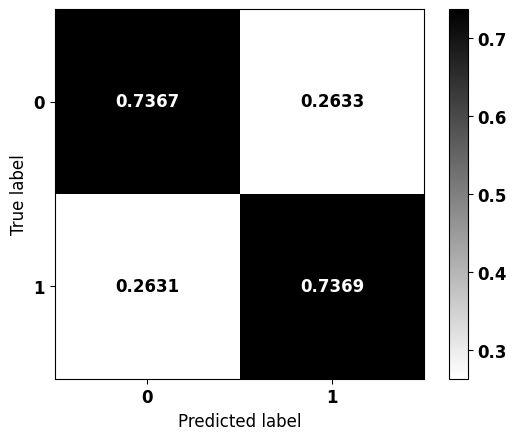


              precision    recall  f1-score   support

           0     0.3555    0.7367    0.4796      3315
           1     0.9342    0.7369    0.8239     16829

    accuracy                         0.7369     20144
   macro avg     0.6449    0.7368    0.6518     20144
weighted avg     0.8390    0.7369    0.7673     20144



In [ ]:
# Criação e treinamento do modelo Random Forest
rf = RandomForestClassifier(random_state=seed,
                            class_weight={0:6.811, 1:1},
                            max_depth=10,
                            criterion='entropy')

rf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(rf, X_test, y_test)

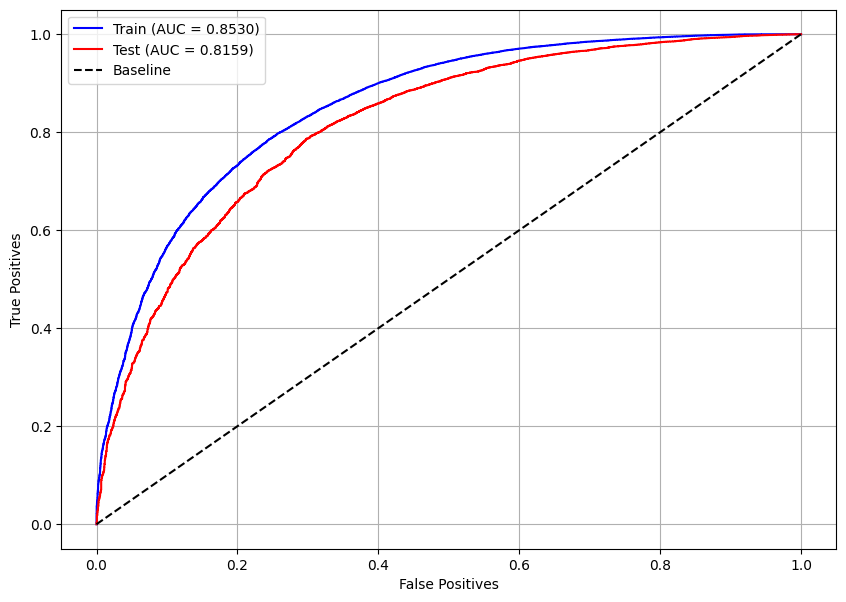

In [ ]:
# Curva ROC
plot_roc_curve(rf, X_train, X_test, y_train, y_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


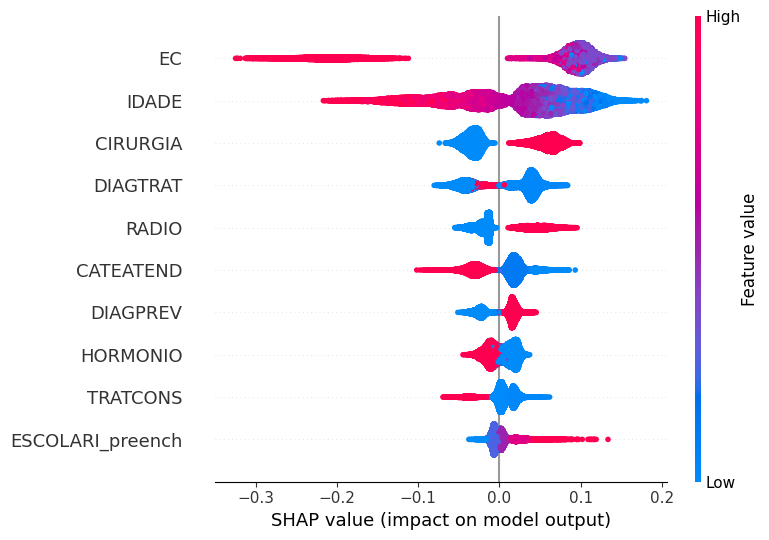

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(rf, X_train, feat_cols)

### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 7)
    max_samples = trial.suggest_float('max_samples', 0.7, 1.0, step=0.1)
    # optimizer = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    cls = RandomForestClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_samples=max_samples,
                                #  criterion=optimizer,
                                 random_state=seed,
                                 n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhor tentativa
studyRF.best_trial

FrozenTrial(number=83, state=TrialState.COMPLETE, values=[0.8561688661219347], datetime_start=datetime.datetime(2023, 10, 15, 4, 16, 13, 826937), datetime_complete=datetime.datetime(2023, 10, 15, 4, 17, 48, 226671), params={'n_estimators': 141, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_samples': 0.7999999999999999, 'criterion': 'gini'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=7, log=False, low=1, step=1), 'max_samples': FloatDistribution(high=1.0, log=False, low=0.7, step=0.1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, trial_id=83, value=None)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 141,
 'max_depth': 10,
 'min_samples_split': 2,
 'min_samples_leaf': 6,
 'max_samples': 0.7999999999999999,
 'criterion': 'gini'}

In [ ]:
pesos = np.round(np.arange(6.78, 6.85, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:i, 1:1}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

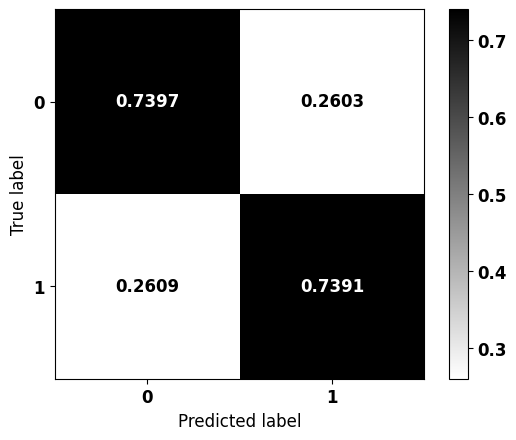


              precision    recall  f1-score   support

           0     0.3583    0.7397    0.4828      3315
           1     0.9351    0.7391    0.8256     16829

    accuracy                         0.7392     20144
   macro avg     0.6467    0.7394    0.6542     20144
weighted avg     0.8402    0.7392    0.7692     20144



In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:6.801, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

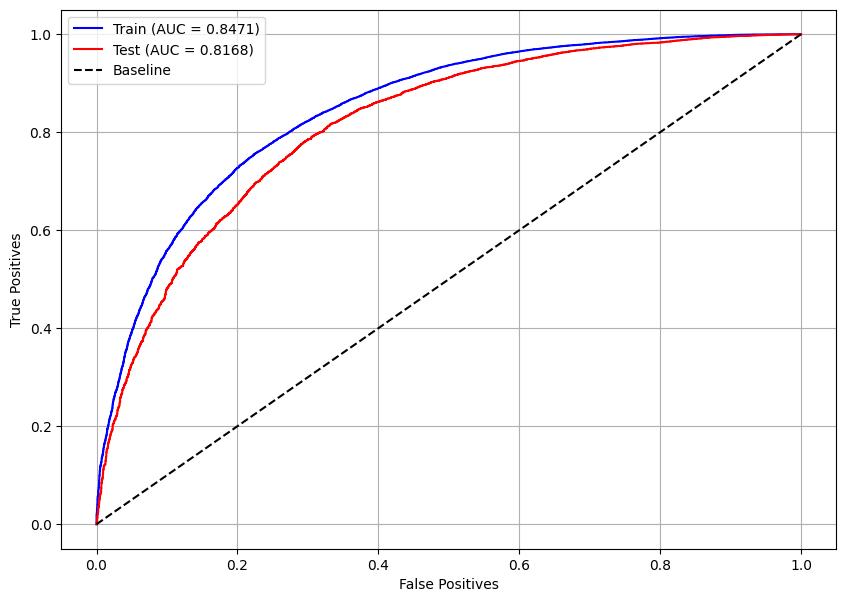

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 141,
 'max_depth': 10,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_samples': 1.0,
 'criterion': 'gini'}

In [ ]:
pesos = np.round(np.arange(6.75, 6.8, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:i, 1:1}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

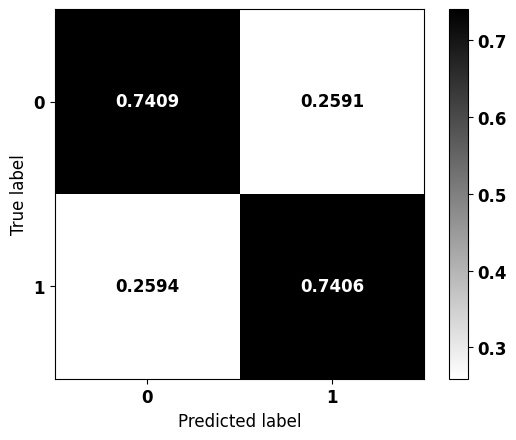


              precision    recall  f1-score   support

           0     0.3600    0.7409    0.4846      3315
           1     0.9355    0.7406    0.8267     16829

    accuracy                         0.7406     20144
   macro avg     0.6478    0.7407    0.6556     20144
weighted avg     0.8408    0.7406    0.7704     20144



In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:6.754, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

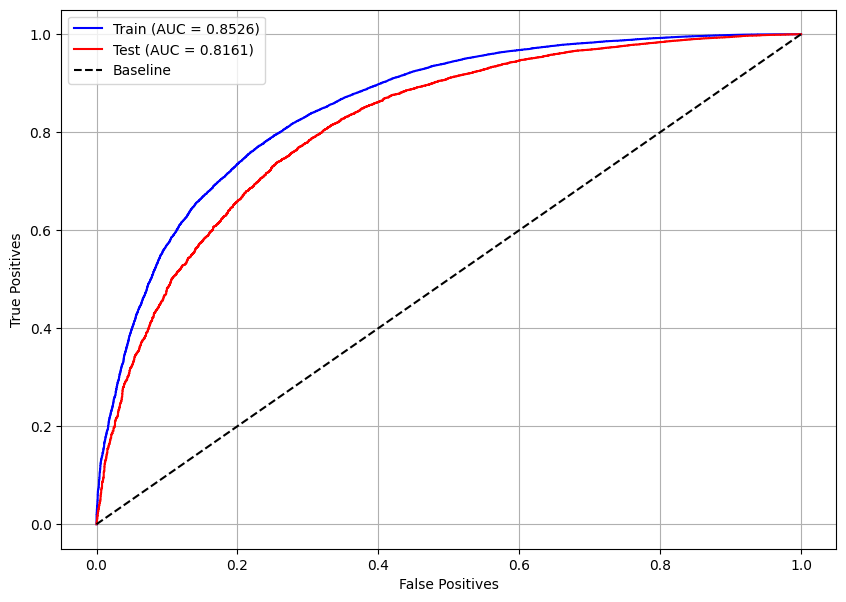

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 85,
 'max_depth': 10,
 'min_samples_split': 6,
 'min_samples_leaf': 3,
 'max_samples': 0.7999999999999999}

In [ ]:
pesos = np.round(np.arange(6.75, 6.83, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:i, 1:1}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

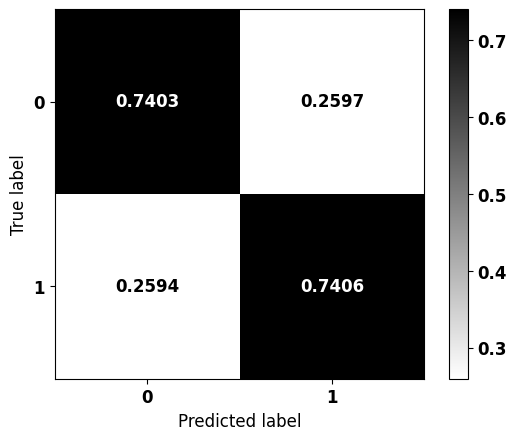


              precision    recall  f1-score   support

           0     0.3599    0.7403    0.4843      3315
           1     0.9354    0.7406    0.8267     16829

    accuracy                         0.7406     20144
   macro avg     0.6476    0.7404    0.6555     20144
weighted avg     0.8407    0.7406    0.7703     20144



In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:6.786, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

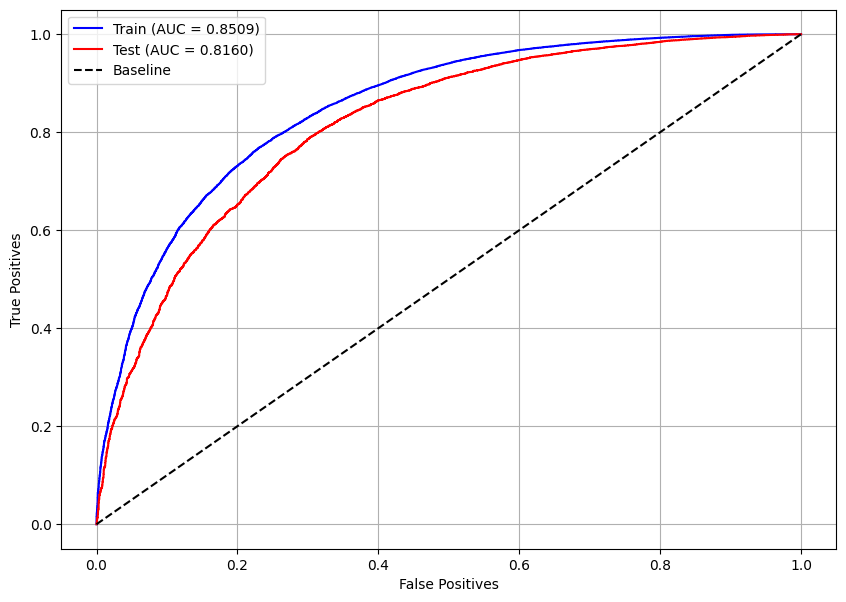

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

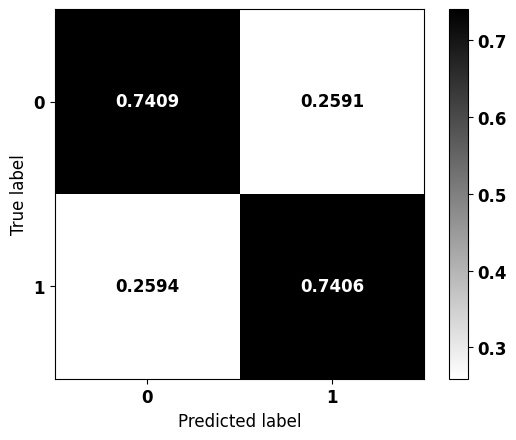


              precision    recall  f1-score   support

           0     0.3600    0.7409    0.4846      3315
           1     0.9355    0.7406    0.8267     16829

    accuracy                         0.7406     20144
   macro avg     0.6478    0.7407    0.6556     20144
weighted avg     0.8408    0.7406    0.7704     20144



In [ ]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 141, 'max_depth': 10, 'min_samples_split': 10,
          'min_samples_leaf': 1, 'max_samples': 1.0, 'criterion': 'gini'}

params['random_state'] = seed
params['class_weight'] = {0:6.754, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

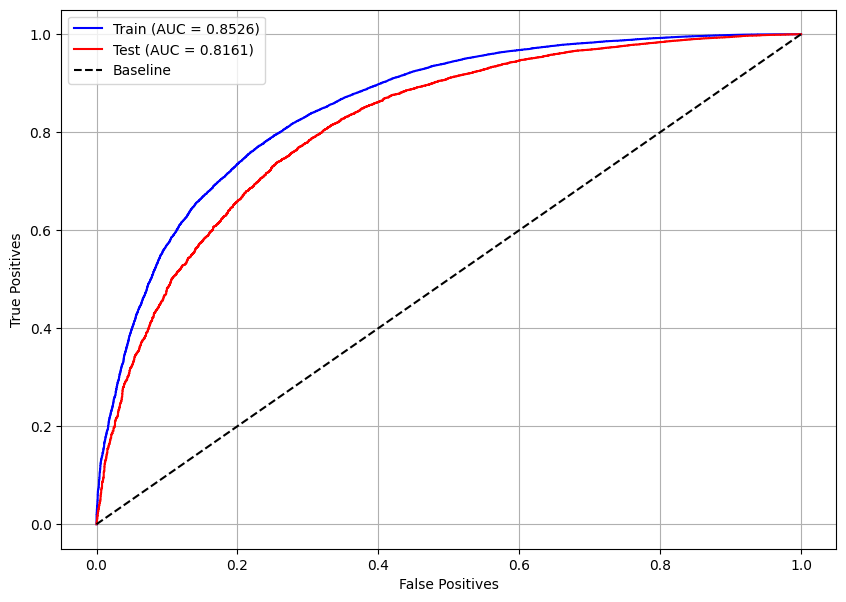

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

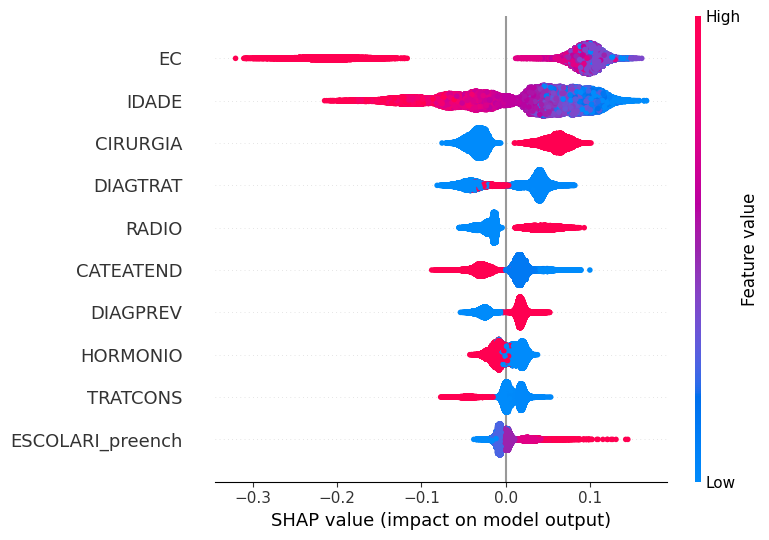

In [ ]:
# Importância das features pelos valores SHAP do modelo otimizado
plot_shap_values(rf_optuna, X_train, feat_cols)

## **XGBoost**


### **Modelo base**

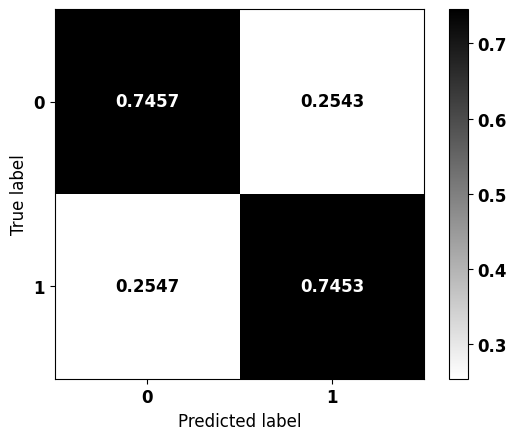


              precision    recall  f1-score   support

           0     0.3657    0.7457    0.4908      3315
           1     0.9370    0.7453    0.8302     16829

    accuracy                         0.7453     20144
   macro avg     0.6514    0.7455    0.6605     20144
weighted avg     0.8430    0.7453    0.7744     20144



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=5,
                    scale_pos_weight=0.1627,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

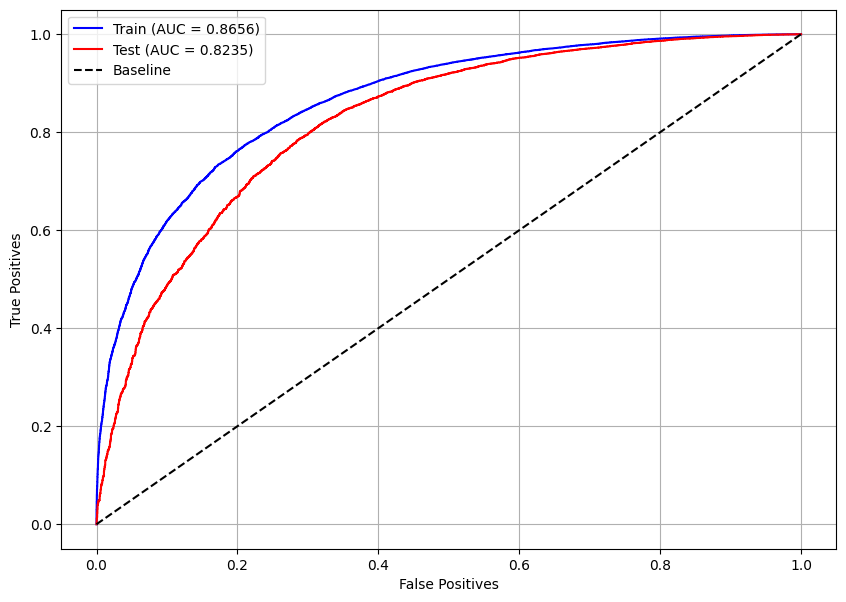

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

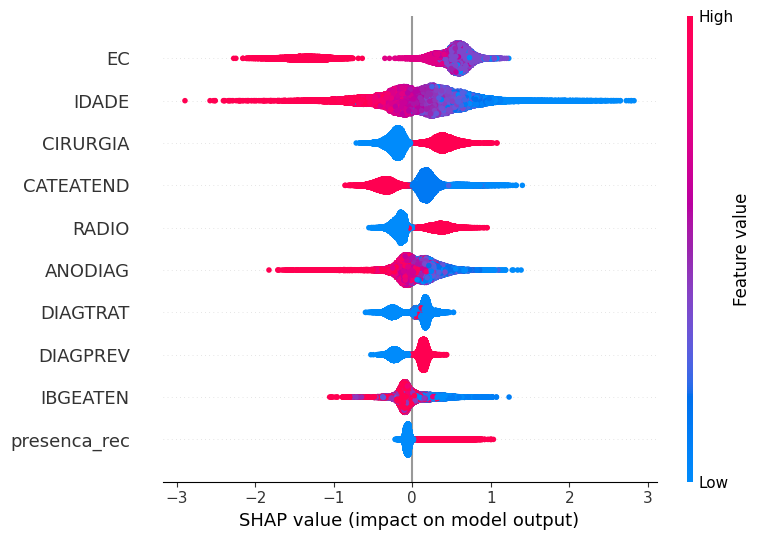

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhor tentativa
studyXGB.best_trial

FrozenTrial(number=26, state=TrialState.COMPLETE, values=[0.8609346287630025], datetime_start=datetime.datetime(2023, 10, 15, 19, 37, 45, 450222), datetime_complete=datetime.datetime(2023, 10, 15, 19, 37, 55, 798958), params={'n_estimators': 68, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.2, 'min_child_weight': 2, 'colsample_bytree': 0.4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=6, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.05), 'gamma': FloatDistribution(high=0.3, log=False, low=0.0, step=0.1), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=26, value=None)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 68,
 'max_depth': 5,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 2,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(0.16, 0.20, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

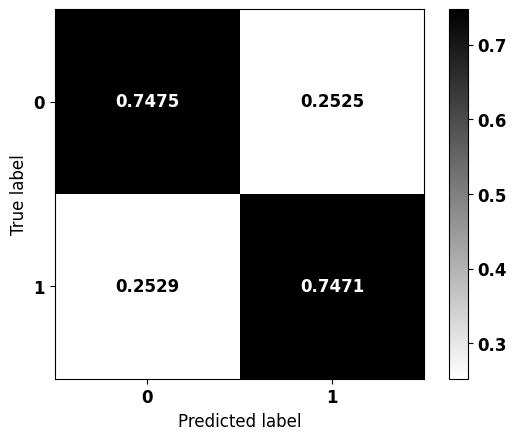


              precision    recall  f1-score   support

           0     0.3680    0.7475    0.4932      3315
           1     0.9376    0.7471    0.8316     16829

    accuracy                         0.7472     20144
   macro avg     0.6528    0.7473    0.6624     20144
weighted avg     0.8438    0.7472    0.7759     20144



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.17

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

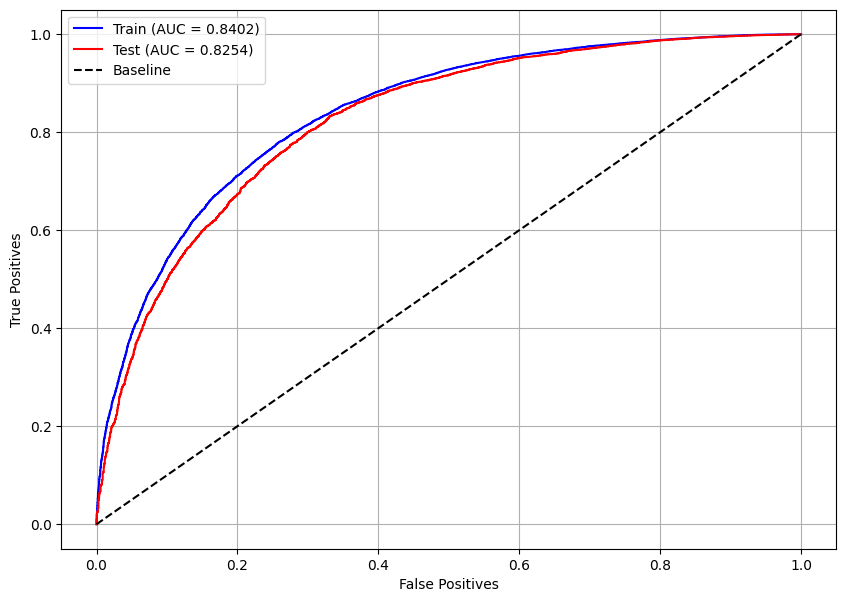

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 146,
 'max_depth': 5,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.2,
 'min_child_weight': 4,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(0.16, 0.20, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

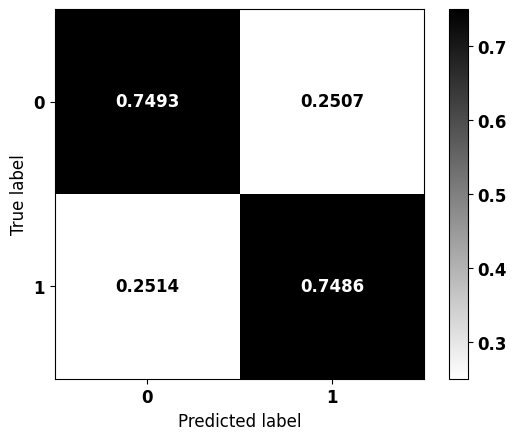


              precision    recall  f1-score   support

           0     0.3700    0.7493    0.4954      3315
           1     0.9381    0.7486    0.8327     16829

    accuracy                         0.7488     20144
   macro avg     0.6540    0.7490    0.6641     20144
weighted avg     0.8446    0.7488    0.7772     20144



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.1687

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

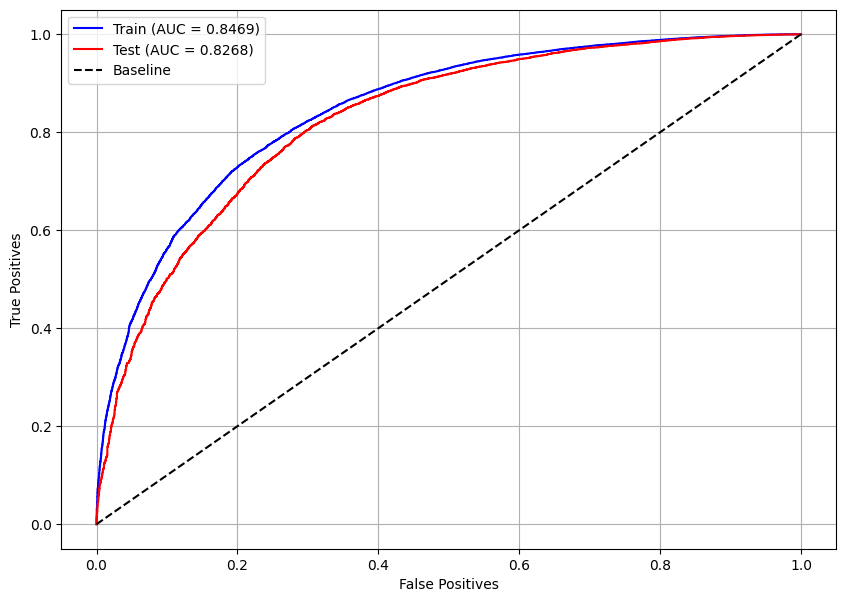

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 116,
 'max_depth': 5,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.0,
 'min_child_weight': 6,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(0.16, 0.19, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

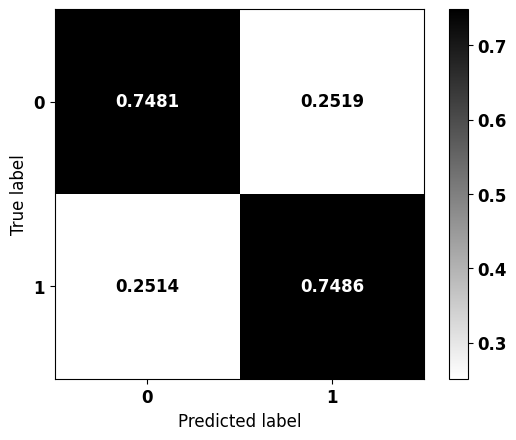


              precision    recall  f1-score   support

           0     0.3696    0.7481    0.4948      3315
           1     0.9378    0.7486    0.8326     16829

    accuracy                         0.7486     20144
   macro avg     0.6537    0.7484    0.6637     20144
weighted avg     0.8443    0.7486    0.7770     20144



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.1692

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

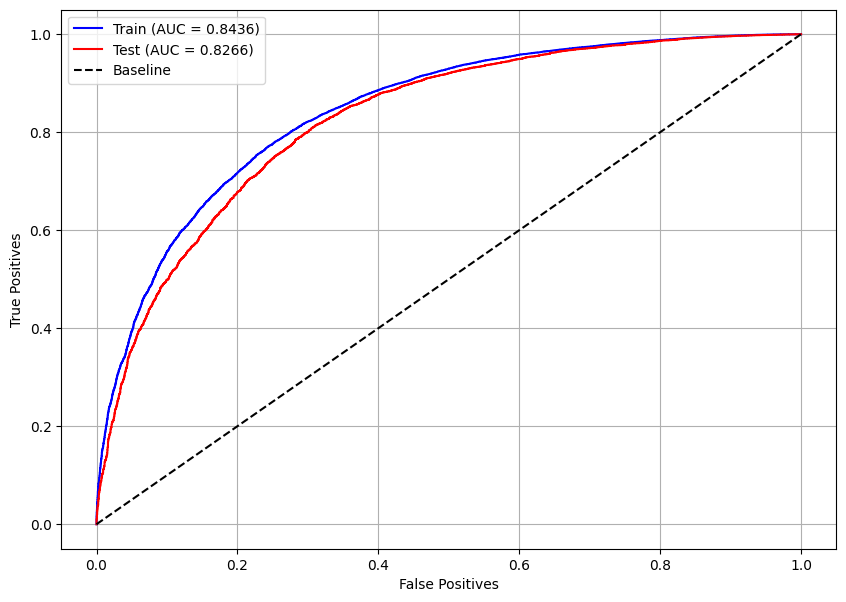

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

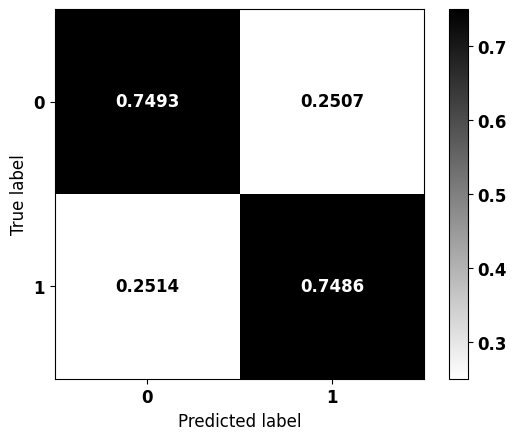


              precision    recall  f1-score   support

           0     0.3700    0.7493    0.4954      3315
           1     0.9381    0.7486    0.8327     16829

    accuracy                         0.7488     20144
   macro avg     0.6540    0.7490    0.6641     20144
weighted avg     0.8446    0.7488    0.7772     20144



In [ ]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 146, 'max_depth': 5, 'learning_rate': 0.15,
          'gamma': 0.2, 'min_child_weight': 4, 'colsample_bytree': 0.4}

params['random_state'] = seed
params['scale_pos_weight'] = 0.1687

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

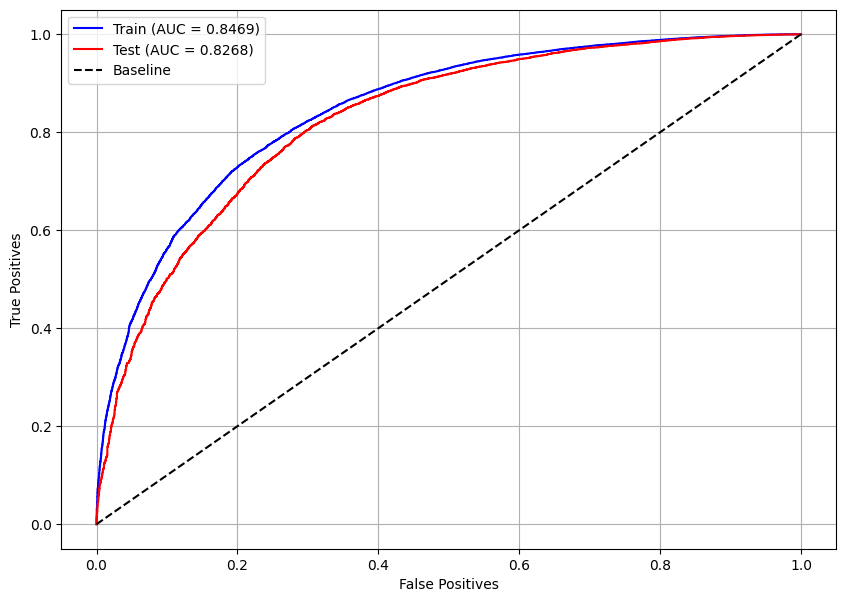

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

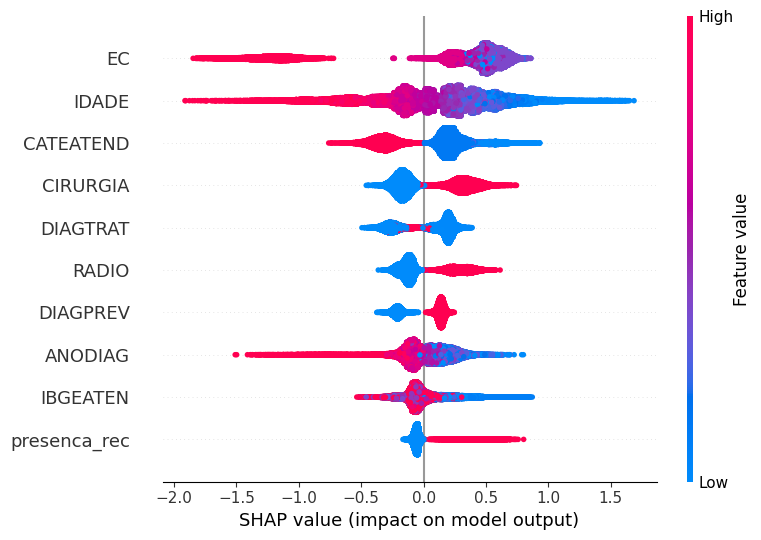

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

## **LightGBM**


### **Modelo base**

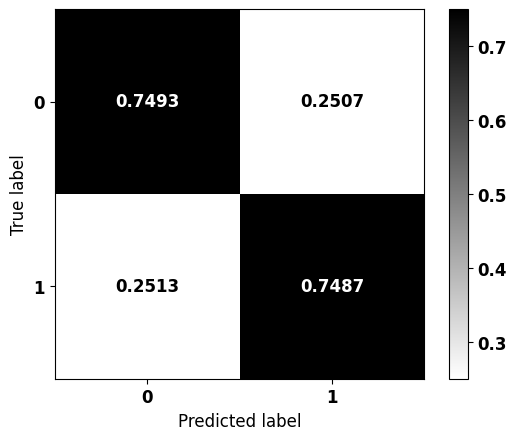


              precision    recall  f1-score   support

           0     0.3700    0.7493    0.4954      3315
           1     0.9381    0.7487    0.8328     16829

    accuracy                         0.7488     20144
   macro avg     0.6541    0.7490    0.6641     20144
weighted avg     0.8446    0.7488    0.7773     20144



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:5.859, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

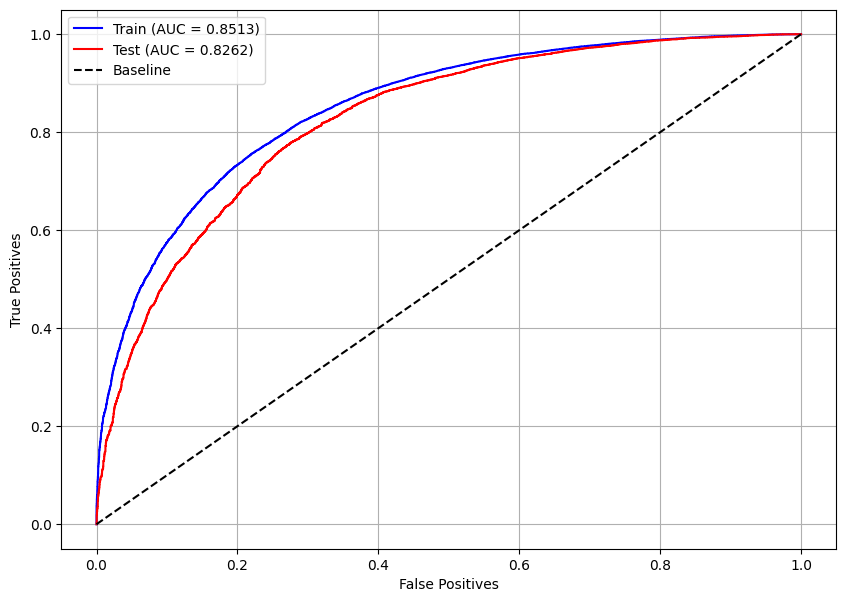

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


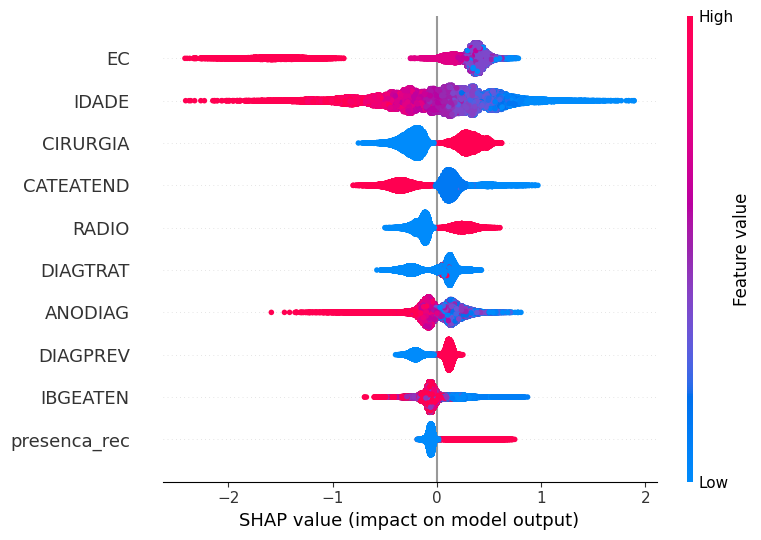

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhor tentativa
studyLGBM.best_trial

FrozenTrial(number=9, state=TrialState.COMPLETE, values=[0.8609842346483776], datetime_start=datetime.datetime(2023, 10, 15, 20, 52, 12, 735063), datetime_complete=datetime.datetime(2023, 10, 15, 20, 52, 34, 176359), params={'n_estimators': 117, 'max_depth': 8, 'learning_rate': 0.11, 'min_child_weight': 3, 'colsample_bytree': 0.6000000000000001}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=8, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.01), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=9, value=None)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 117,
 'max_depth': 8,
 'learning_rate': 0.11,
 'min_child_weight': 3,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(5.9, 6.1, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

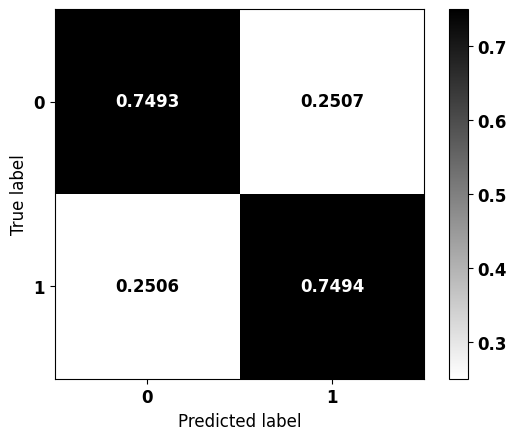


              precision    recall  f1-score   support

           0     0.3706    0.7493    0.4960      3315
           1     0.9382    0.7494    0.8332     16829

    accuracy                         0.7494     20144
   macro avg     0.6544    0.7493    0.6646     20144
weighted avg     0.8448    0.7494    0.7777     20144



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:5.946, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

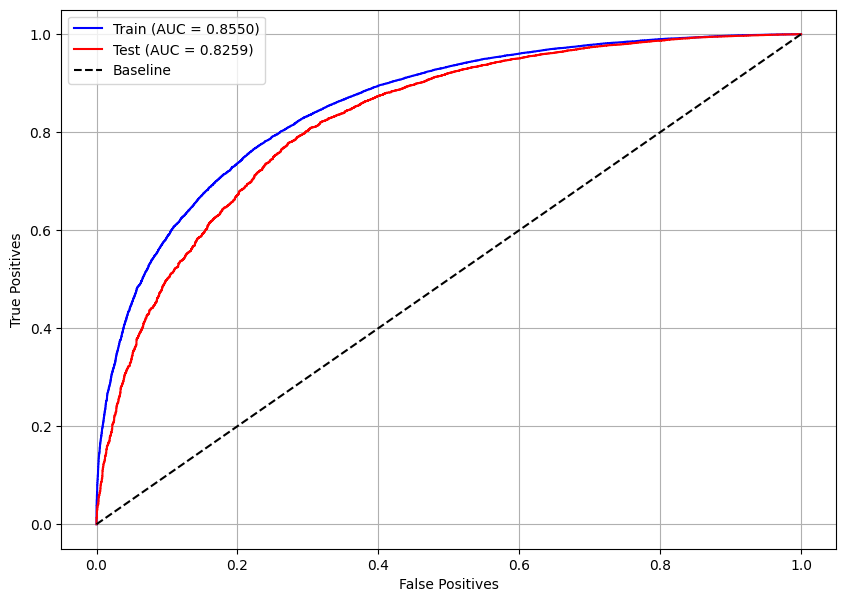

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 143,
 'max_depth': 8,
 'learning_rate': 0.1,
 'min_child_weight': 3,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(5.9, 6.1, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

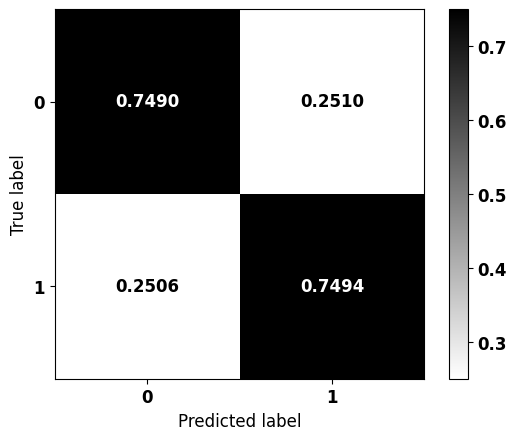


              precision    recall  f1-score   support

           0     0.3705    0.7490    0.4958      3315
           1     0.9381    0.7494    0.8332     16829

    accuracy                         0.7493     20144
   macro avg     0.6543    0.7492    0.6645     20144
weighted avg     0.8447    0.7493    0.7777     20144



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:5.98, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

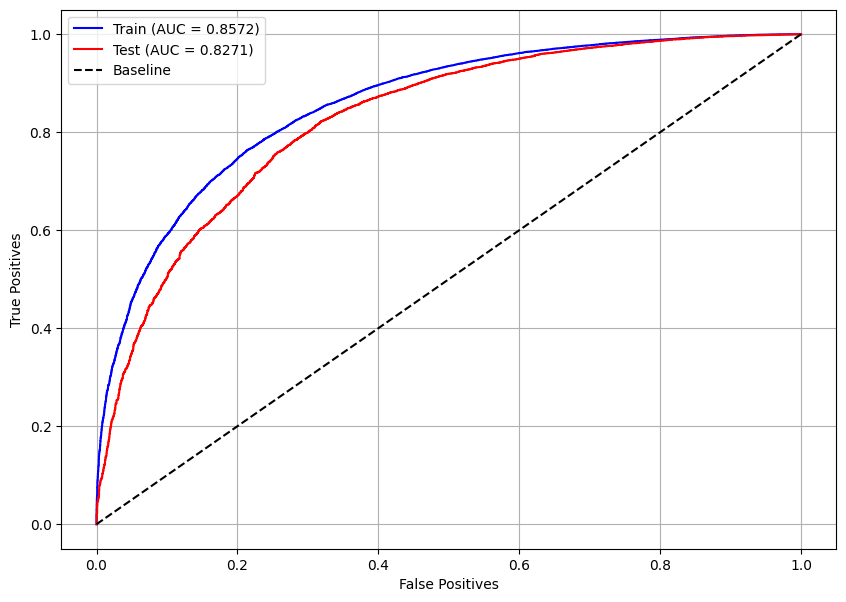

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 102,
 'max_depth': 8,
 'learning_rate': 0.12000000000000001,
 'min_child_weight': 3,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(5.9, 6.1, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

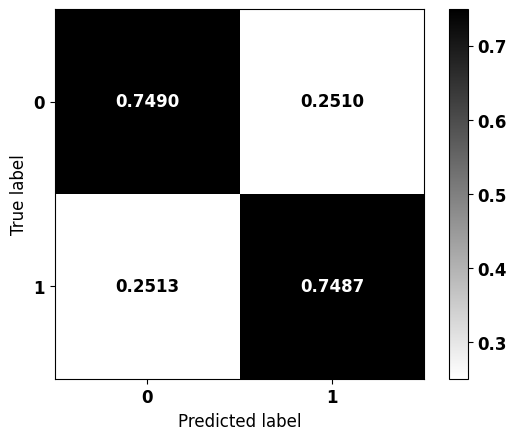


              precision    recall  f1-score   support

           0     0.3699    0.7490    0.4953      3315
           1     0.9381    0.7487    0.8328     16829

    accuracy                         0.7488     20144
   macro avg     0.6540    0.7489    0.6640     20144
weighted avg     0.8446    0.7488    0.7772     20144



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:5.951, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

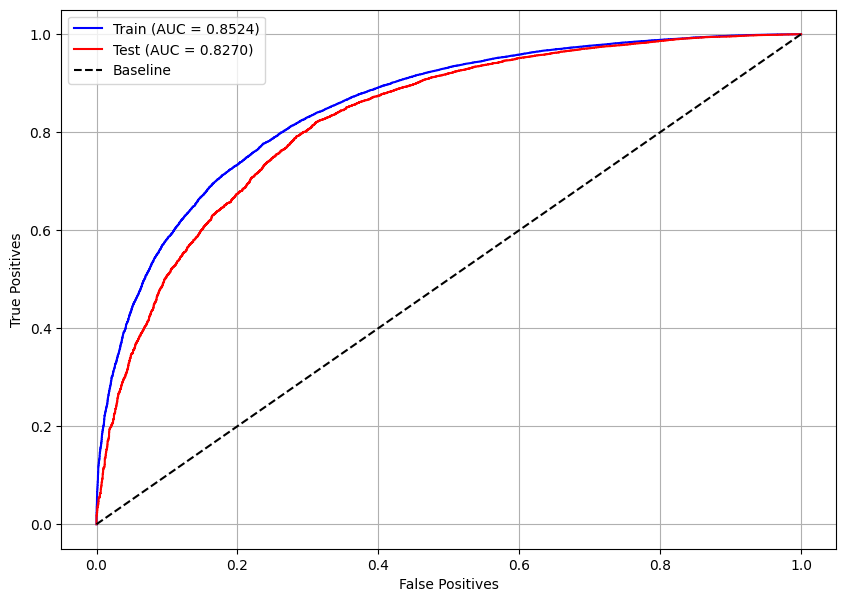

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

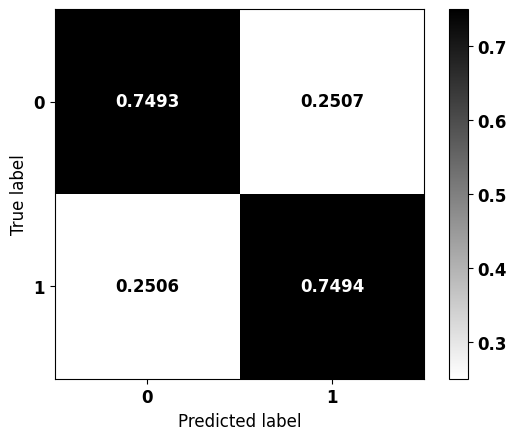


              precision    recall  f1-score   support

           0     0.3706    0.7493    0.4960      3315
           1     0.9382    0.7494    0.8332     16829

    accuracy                         0.7494     20144
   macro avg     0.6544    0.7493    0.6646     20144
weighted avg     0.8448    0.7494    0.7777     20144



In [14]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 117, 'max_depth': 8, 'learning_rate': 0.11,
          'min_child_weight': 3, 'colsample_bytree': 0.6}

params['random_state'] = seed
params['class_weight'] = {0:5.946, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

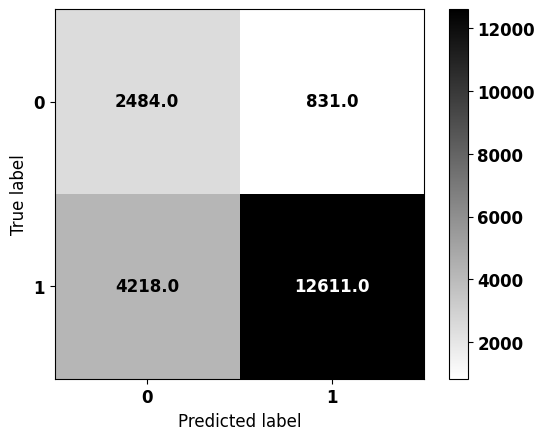


              precision    recall  f1-score   support

           0     0.3706    0.7493    0.4960      3315
           1     0.9382    0.7494    0.8332     16829

    accuracy                         0.7494     20144
   macro avg     0.6544    0.7493    0.6646     20144
weighted avg     0.8448    0.7494    0.7777     20144



In [15]:
plot_confusion_matrix(lgbm_optuna, X_test, y_test, norm=False)

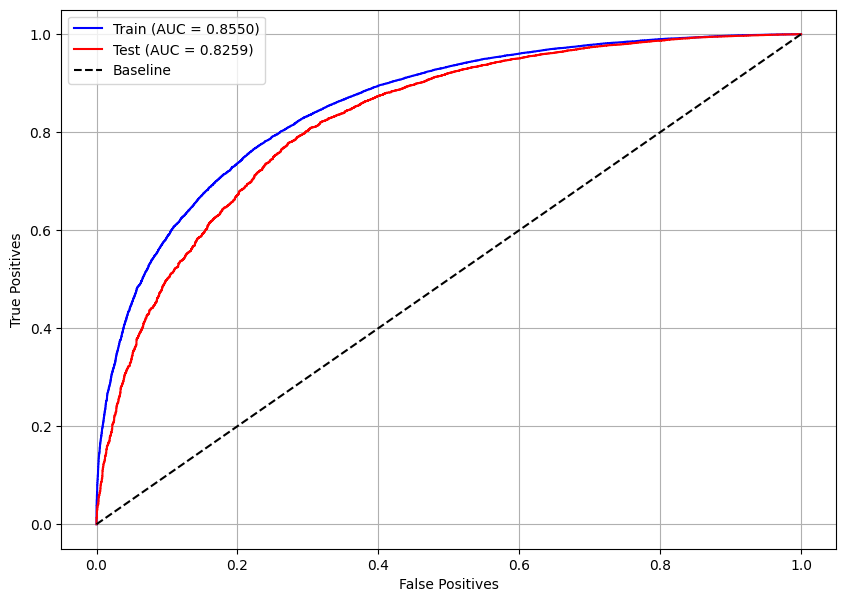

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

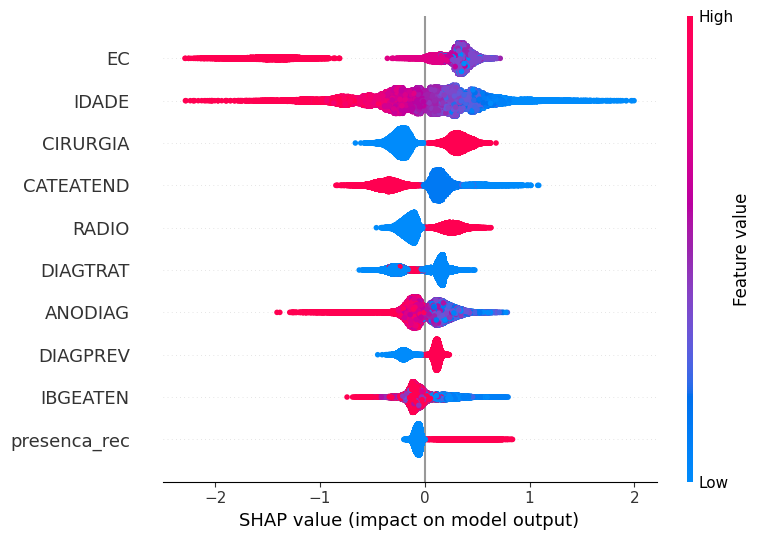

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

## **Voting Classifier**


In [ ]:
# Melhores hiperparâmetros do modelo Random Forest
rf_score = rf.score(X_test, y_test)
optuna_score = rf_optuna.score(X_test, y_test)
print(f'Accuracy: RF = {rf_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= rf_score:
    params_rf = rf_optuna.get_params()
    print('Otimizado venceu')
else:
    params_rf = rf.get_params()
    print('Modelo inicial venceu')

Accuracy: RF = 0.7369, Optuna = 0.7406

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7453, Optuna = 0.7488

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7488, Optuna = 0.7494

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# Random Forest
best_rf = RandomForestClassifier()
best_rf.set_params(**params_rf)

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 5.946, 1: 1}, colsample_bytree=0.6,
               learning_rate=0.11, max_depth=8, min_child_weight=3,
               n_estimators=117, random_state=7, verbose=-1)

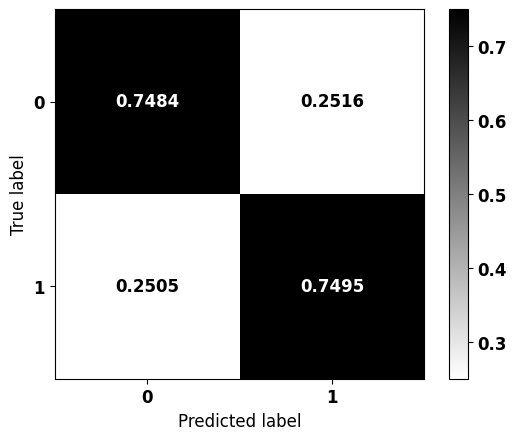


              precision    recall  f1-score   support

           0     0.3705    0.7484    0.4957      3315
           1     0.9380    0.7495    0.8332     16829

    accuracy                         0.7494     20144
   macro avg     0.6543    0.7490    0.6644     20144
weighted avg     0.8446    0.7494    0.7777     20144



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[#('RandomForest', best_rf),
                                   ('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

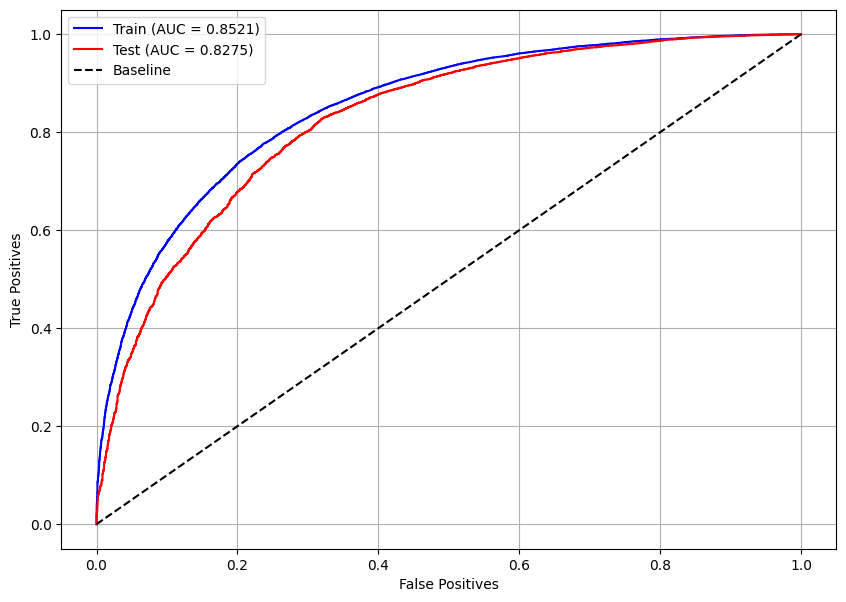

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

## **Testes com outros tipos de câncer**

In [ ]:
# Melhor modelo
models = [rf, rf_optuna, xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 5.946, 1: 1}, colsample_bytree=0.6,
               learning_rate=0.11, max_depth=8, min_child_weight=3,
               n_estimators=117, random_state=7, verbose=-1)


In [ ]:
# Colunas que não serão utilizadas na predição cruzada
list_drop = list_drop + [lb]
list_drop

['TRATHOSP',
 'TOPO',
 'TOPOGRUP',
 'obito_geral',
 'sobrevida_ano1',
 'sobrevida_ano5',
 'sobrevida_ano3']

### **Colorretal**

In [ ]:
df_colorretal = pd.read_csv('/content/colorretal.csv')
print(df_colorretal.shape)
df_colorretal.head(3)

(60887, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,28,2,3548708,9,1,C180,C18,III,E,0,...,1,3550308,1,3.0,0,0,1,1,0,0
1,26,2,3550308,9,1,C180,C18,III,A,0,...,6,3550308,2,2.0,1,0,0,1,1,1
2,22,2,3503208,9,2,C180,C18,IV,C,0,...,13,3503208,1,4.0,1,0,1,0,0,0


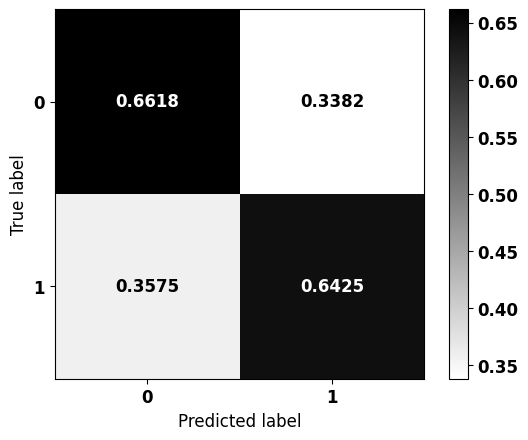


              precision    recall  f1-score   support

           0     0.6070    0.6618    0.6332     24725
           1     0.6947    0.6425    0.6676     29624

    accuracy                         0.6512     54349
   macro avg     0.6509    0.6521    0.6504     54349
weighted avg     0.6548    0.6512    0.6519     54349



In [ ]:
pred_cruzada(df_colorretal, best, list_drop, lb, enc, norm)

### **Pulmão**

In [ ]:
df_pulmao = pd.read_csv('/content/pulmao.csv')
print(df_pulmao.shape)
df_pulmao.head(3)

(38646, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,28,2,3520103,9,1,C340,C34,IIIB,J,1,...,13,3505500,2,2.0,0,0,1,0,0,0
1,28,2,3554508,9,1,C340,C34,IIIB,C,0,...,8,3525300,2,3.0,0,1,1,1,0,0
2,27,2,3507001,2,2,C340,C34,IV,F,0,...,8,3525300,2,4.0,0,0,1,0,0,0


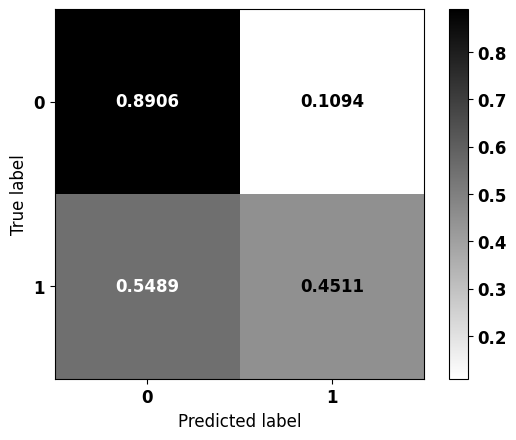


              precision    recall  f1-score   support

           0     0.9148    0.8906    0.9026     31755
           1     0.3839    0.4511    0.4148      4797

    accuracy                         0.8330     36552
   macro avg     0.6494    0.6709    0.6587     36552
weighted avg     0.8452    0.8330    0.8386     36552



In [ ]:
pred_cruzada(df_pulmao, best, list_drop, lb, enc, norm)

### **Mama**

In [ ]:
df_mama = pd.read_csv('/content/mama.csv')
print(df_mama.shape)
df_mama.head(3)

(117338, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,102,2,3550308,9,1,C509,C50,IIIB,D,0,...,6,3550308,2,3.0,1,1,1,1,0,0
1,28,2,3547809,9,2,C500,C50,I,G,0,...,1,3547809,1,4.0,1,0,1,1,1,1
2,27,2,3512001,2,2,C500,C50,I,H,0,...,13,3505500,2,4.0,0,1,0,1,1,1


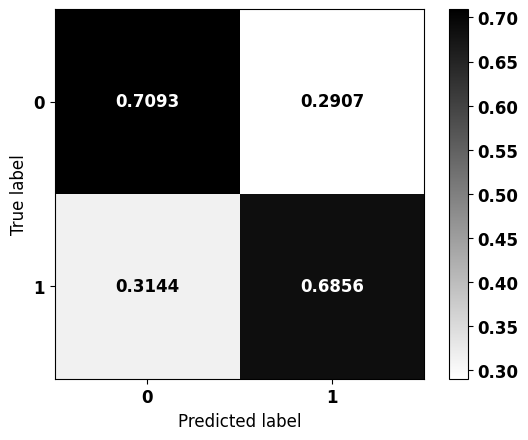


              precision    recall  f1-score   support

           0     0.3646    0.7093    0.4817     20467
           1     0.9027    0.6856    0.7793     80458

    accuracy                         0.6904    100925
   macro avg     0.6336    0.6975    0.6305    100925
weighted avg     0.7935    0.6904    0.7189    100925



In [ ]:
pred_cruzada(df_mama, best, list_drop, lb, enc, norm)

### **Colo de Útero**

In [ ]:
df_colo_utero = pd.read_csv('/content/colo_utero.csv')
print(df_colo_utero.shape)
df_colo_utero.head(3)

(23306, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,27,2,3548906,9,2,C530,C53,IIIB,B,0,...,13,3503208,1,4.0,0,0,1,1,0,0
1,29,2,3518701,9,1,C530,C53,IB2,E,0,...,7,3518701,1,3.0,1,0,1,1,0,0
2,29,2,3522109,2,2,C530,C53,IB1,A,0,...,7,3550308,2,3.0,0,1,0,1,1,1


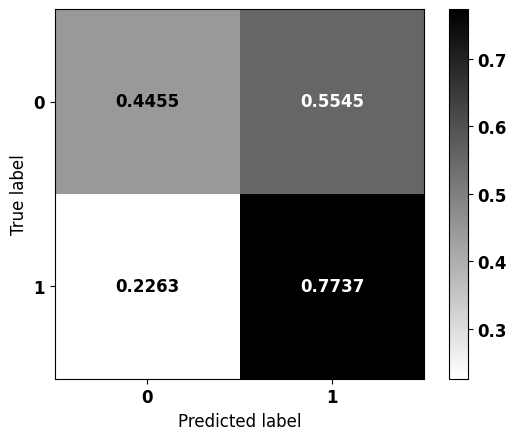


              precision    recall  f1-score   support

           0     0.6032    0.4455    0.5125      9143
           1     0.6437    0.7737    0.7027     11837

    accuracy                         0.6306     20980
   macro avg     0.6234    0.6096    0.6076     20980
weighted avg     0.6260    0.6306    0.6198     20980



In [ ]:
pred_cruzada(df_colo_utero, best, list_drop, lb, enc, norm)

### **Pele**

In [ ]:
df_pele = pd.read_csv('/content/pele.csv')
print(df_pele.shape)
df_pele.head(3)

(183164, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,101,2,3543402,9,1,C443,C44,I,I,0,...,13,3543402,2,2.0,1,0,1,1,0,0
1,100,1,3522802,2,1,C443,C44,II,A,0,...,9,3525300,2,1.0,0,0,1,1,0,0
2,105,2,3546603,9,1,C447,C44,I,A,0,...,12,3505500,2,1.0,0,0,1,0,0,0


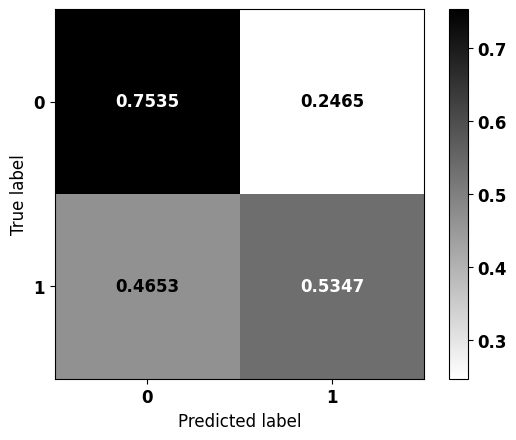


              precision    recall  f1-score   support

           0     0.3303    0.7535    0.4592     22949
           1     0.8769    0.5347    0.6643     75360

    accuracy                         0.5858     98309
   macro avg     0.6036    0.6441    0.5618     98309
weighted avg     0.7493    0.5858    0.6164     98309



In [ ]:
pred_cruzada(df_pele, best, list_drop, lb, enc, norm)